In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import math
from sklearn import linear_model, decomposition, datasets
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [3]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
4649261,QUEENSBERRY,ERROL STREET,QUEENSBERRY STREET,VICTORIA STREET,5,10195W,13/02/2012 11:55:02 AM,13/02/2012 12:26:23 PM,1881,1P TKT A M-F 7:30-18:30,0,641,3214
11214055,JOLIMONT,LANSDOWNE STREET,ALBERT STREET,CATHEDRAL PLACE,2,11886E,31/08/2012 10:17:04 AM,31/08/2012 12:02:07 PM,6303,2P MTR M-F 7:30-18:30,0,869,6312
5586217,VICTORIA MARKET,FRANKLIN STREET,WILLAM STREET,QUEEN STREET,1,C6756,11/03/2012 03:02:42 PM,11/03/2012 03:31:32 PM,1730,2P SUN 7:30-18:30,0,681,2936
7179511,RIALTO,BOURKE STREET,KING STREET,WILLIAM STREET,3,2470N,01/05/2012 07:35:40 PM,01/05/2012 07:38:29 PM,169,P MTR M-SAT 19:30-20:30,0,123,1483
4262673,RIALTO,KING STREET,BOURKE STREET,LT COLLINS STREET,5,1449W,01/02/2012 01:31:33 PM,01/02/2012 01:39:08 PM,455,1/2P MTR M-F 10:00-16:00,0,839,888


In [4]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [5]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [6]:
#Target field identification
duration = parkingdata['Duration of Parking Event (in seconds)'].copy()

print('Minimum parking duration (seconds): ' + str(duration.min()))
print('Maximum parking duration (seconds): ' + str(duration.max()))
print('\nMinimum parking duration (hour): ' + str(duration.min()/3600))
print('Maximum parking duration (hour): ' + str(duration.max()/3600))
print('\nMinimum parking duration is under [' + str(math.trunc(duration.min()/3600) + 1) + '] hours')
print('Maximum parking duration is under [' + str(math.trunc(duration.max()/3600) + 1) + '] hours')

durList = []
static = 1
df = pd.DataFrame()

for record in duration.values:
    hour = 3600
    index = 0
    while static == 1:
        if record < hour:
#             print("\nDuration in seconds: " + str(record))
            data = math.trunc(record/3600) + 1
            durList.append(data)
#             print("Duration is under " + str(data) + " hours")
            break
        else:
            hour += 3600

df.insert(0, 'Duration (Hours)', durList, True)
target = df['Duration (Hours)']
target.head(10)

Minimum parking duration (seconds): 7
Maximum parking duration (seconds): 86264

Minimum parking duration (hour): 0.0019444444444444444
Maximum parking duration (hour): 23.962222222222223

Minimum parking duration is under [1] hours
Maximum parking duration is under [24] hours


0    1
1    2
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    2
Name: Duration (Hours), dtype: int64

In [7]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('In Violation?', axis = 1, inplace = True)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['In Violation?'] = parkingdata['In Violation?']
features['Side Of Street'] = parkingdata['Side Of Street']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,In Violation?,Side Of Street,Street ID,Device ID,Arrival Hour,Departure Hour
4649261,0,0,0,0,0,0,5,641,3214,11,12
11214055,1,1,1,1,1,0,2,869,6312,10,12
5586217,2,2,2,2,2,0,1,681,2936,15,15
7179511,3,3,3,3,3,0,3,123,1483,19,19
4262673,3,4,4,4,4,0,5,839,888,13,13
2236306,4,5,5,5,5,1,3,528,1047,15,16
494902,5,6,6,2,6,0,4,856,2144,7,7
4818672,6,7,7,6,7,0,2,647,166,17,17
8840016,6,7,7,6,8,0,5,647,183,10,10
2280954,7,2,5,0,9,0,3,681,2908,16,17


In [8]:
#Parameter Tuning
         ####NOTE: random_split=1 for test_train
#Define the parameters to tune and the values to tune to
params_dtc = [
    {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [None,1, 2, 4, 10],
        'max_depth': [None, 4, 10, 15],
        'splitter' : ['best', 'random'],
        'min_samples_split':[None,5, 8, 10, 12, 14, 16]
    }
]

In [9]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_dtc = GridSearchCV(estimator = DecisionTreeClassifier(),
                      param_grid = params_dtc, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [10]:
#Fit the model with the dataset
bestModel = gs_dtc.fit(features, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   51.3s finished


In [11]:
#Find the best values for the  parameters of the model (Standard output)
gs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 14,
 'splitter': 'best'}

In [12]:
#Find the best values for the  parameters of the model (Formatted output)
best_criterion = bestModel.best_estimator_.get_params()['criterion']
best_max_depth =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion)
print('Best max_depth: ', best_max_depth )
print('Best min_samples_leaf: ', best_min_samples_leaf )
print('Best min_samples_split: ', best_min_samples_split)
print('Best splitter: ', best_splitter)

Best criterion:  entropy
Best max_depth:  15
Best min_samples_leaf:  4
Best min_samples_split:  14
Best splitter:  best


In [13]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.8303
556,entropy,15.0,10.0,14.0,best,0.8464
557,entropy,15.0,10.0,14.0,random,0.8343
558,entropy,15.0,10.0,16.0,best,0.8462


In [14]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
dtc = metric = DecisionTreeClassifier(criterion = best_criterion, 
                               max_depth = best_max_depth, 
                               min_samples_leaf = best_min_samples_leaf,
                               min_samples_split = best_min_samples_split,
                               splitter = best_splitter,
                               random_state = 0
                               )

In [15]:
# Hill climbing
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = dtc.fit(x_train, y_train)
    cur_Score = dtc.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.7865
Score with 2 selected features: 0.787
Score with 3 selected features: 0.787
Score with 4 selected features: 0.851

Indexs of the desired features
[2, 4, 0, 5]


In [16]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Sign,Area Name,In Violation?
4649261,0,0,0,0
11214055,1,1,1,0
5586217,2,2,2,0
7179511,3,3,3,0
4262673,4,4,3,0
2236306,5,5,4,1
494902,6,6,5,0
4818672,7,7,6,0
8840016,7,8,6,0
2280954,5,9,7,0


In [17]:
bestModel = gs_dtc.fit(features_hc, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2168 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   25.4s finished


In [18]:
gs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'splitter': 'random'}

In [19]:
best_criterion_hc = bestModel.best_estimator_.get_params()['criterion']
best_max_depth_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf_hc =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split_hc =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter_hc =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion_hc)
print('Best max_depth: ', best_max_depth_hc )
print('Best min_samples_leaf: ', best_min_samples_leaf_hc )
print('Best min_samples_split: ', best_min_samples_split_hc)
print('Best splitter: ', best_splitter_hc)

Best criterion:  entropy
Best max_depth:  None
Best min_samples_leaf:  2
Best min_samples_split:  5
Best splitter:  random


In [20]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.8371
556,entropy,15.0,10.0,14.0,best,0.8440
557,entropy,15.0,10.0,14.0,random,0.8367
558,entropy,15.0,10.0,16.0,best,0.8440


In [21]:
dtc = metric = DecisionTreeClassifier(criterion = best_criterion_hc, 
                               max_depth = best_max_depth_hc, 
                               min_samples_leaf = best_min_samples_leaf_hc,
                               min_samples_split = best_min_samples_split_hc,
                               splitter = best_splitter_hc,
                               random_state = 0
                               )

In [22]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = confusion_matrix(y_test,predicted)
print("Confusion Matrix")
print(cm)

#Printing the numerical result of the confusion matrix
print("\n[Train/test split] score: {:.5f}".format(dtc.score(x_test, y_test)))

print(classification_report(y_test, predicted))

Confusion Matrix
[[3900   41    7    4    0    0    0    0    0    0    0    0    0    0
     0]
 [ 431  266   12    0    0    0    0    0    1    0    0    0    0    0
     0]
 [  74   40   51    5    1    2    0    0    0    0    3    0    0    2
     0]
 [  16   21   13    5    0    0    0    0    0    0    0    0    0    0
     0]
 [  11    4   10    0    3    0    0    0    0    0    0    0    0    0
     0]
 [   2    6    4    0    0    0    0    0    1    0    1    0    0    1
     0]
 [   1    1    3    0    1    0    2    0    0    0    0    0    0    0
     0]
 [   3    5    3    0    0    0    0    0    0    0    0    0    0    1
     0]
 [   1    2    1    0    0    0    0    2    0    0    0    0    0    0
     0]
 [   0    2    0    0    0    0    0    0    1    0    0    0    0    0
     0]
 [   5    3    9    0    3    0    0    0    1    0    0    0    0    0
     0]
 [   1    3    1    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   1    1    3    0  

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nDecision Tree mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.84050
[fold 1] score: 0.85300
[fold 2] score: 0.84050
[fold 3] score: 0.84700
[fold 4] score: 0.84300

Decision Tree mean score [5 folds] = 0.8448


In [24]:
#visualise the tree
from sklearn import tree
with open('durationTarget.dot', 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f, feature_names=None, class_names=None, filled=True, rounded=True, special_characters=True)
    



 Accuracy score: 0.84540

 Misclassification Rate: 0.10177

 True Positive Rate: 0.38164

 True Negative Rate: 0.98960

 Precision : 0.86645

 Prevalence : 0.15028

 F score : 0.52988

 False Positive Rate: 0.01040


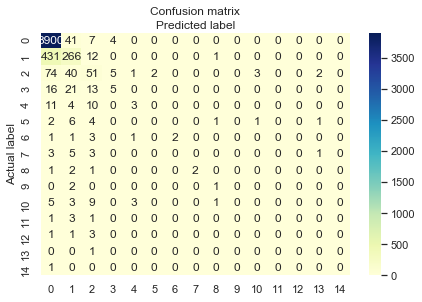

In [25]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(dtc.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

In [26]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.84050
[fold 1] score: 0.85300
[fold 2] score: 0.84050
[fold 3] score: 0.84700
[fold 4] score: 0.84300

KNN mean score [5 folds] = 0.8448
